# Generate Initial and Boundary Conditions from Quasi-analytical settings
### To generate for SAS, Perdigao (to do) and Rico (to do) + perturbations

In [128]:
%matplotlib inline
import matplotlib.pyplot as mp
import numpy as np
import metpy.calc as mpy
import datetime as dt
import metpy.constants as mconst
import xarray as xr
from pylab import *


import scam_forcings_iop as libpy

###### FUNDAMENTAL CONSTANTS ######
            
Lv = mconst.water_heat_vaporization.magnitude  # Latent heat of vaporization
pref = 100.*mconst.pot_temp_ref_press.magnitude # mb->Pa
cp_air = mconst.dry_air_spec_heat_press.magnitude # Specific heat for dry airo
r_gas = 1000.*mconst.dry_air_gas_constant.magnitude   # Specific gas constant for dry air
r_cp = r_gas/cp_air    # r/cp
grav = mconst.earth_gravity.magnitude       # Gravity ave.

###### TIME CONSTANTS ######

pd = 86400 # Seconds per day
sph = 3600  # Seconds per hour
mpd = 1440  # Mins per day
spm = 60    # Seconds per minute.
p0 = 1000.


In [129]:
"""
    SCAM FORCINGS GENERATION OF IC/BC PARAMETERS #####
    
    SAS: Southeast Atmopshere Study
    From EGU/ACP website: https://www.atmos-chem-phys.net/16/7725/2016/
    
    PERDIGAO: 
    
"""

importlib.reload(libpy) # Required because I am constantly editing the lib/case py file


out_file_name = ''
out_file_desc = ''
dir_main = '/Users/rneale/Documents/NCAR/PBL/PBL_py_data/'

iop_case = 'SAS'


lno_lsf  = True # Set large scale forcings to zero.
liop_lev = False # Take levels from existing IOP

############### NEED
### PARAMS FOR q-tail through trop/strat-opause ###

qtail = 2.0  # Value of q at which to start tailing
pexp = 100. # Pressure at which to do 2/3 of the reduction (higher values squeeze closer to zero q)
dqdt_mult = 20. # Multiplier to send q to zero faster with height.


########## GRAB IOP CASE INFO ###########
case_iop = libpy.scam_iop_settings(iop_case,dir_main)

nplevs = 400 ## Vertical Pressure Grid
pmin = 10000.

ps = case_iop['ps']
pmax = ps

## Chemicial species and emissions that need to initialized and  
#chem_spec = {}
#chem_spec['O3'] =  
#chem_sepc['H2O2']
#chem_spec['CO']
#chem_spec[]'NO']


#importlib.reload(mypy) # Required because I am constantly editing scam_func.py


### Derived ###

#tperiod = (loc_tend-loc_tstart)*sph+dtime    # Time length (hours*sph=sec) for whole of IOP
#iop_zstart = (loc_tstart+zoffset)*sph        # 12Z = 6AM MST (US)

#tperiod_sflux = (sflux_tend-sflux_tstart)*sph+dtime  # Period (length) of daytime +ve SH fluxes
#tperiod_lflux = (lflux_tend-lflux_tstart)*sph+dtime  # Period (length) of daytime +ve LH fluxes

## No dtime offset!

tperiod    = (case_iop['loc_tend']-case_iop['loc_tstart'])*sph  # Time length (hours*sph=sec) for whole of IOP
iop_zstart = (case_iop['loc_tstart']+case_iop['zoffset'])*sph        # 12Z = 6AM MST (US)

tperiod_sflux = (case_iop['sflux_tend']-case_iop['sflux_tstart'])*sph # Period (length) of daytime +ve SH fluxes
tperiod_lflux = (case_iop['lflux_tend']-case_iop['lflux_tstart'])*sph # Period (length) of daytime +ve LH fluxes

sflux_zstart = (case_iop['sflux_tstart']+case_iop['zoffset'])*sph
lflux_zstart = (case_iop['lflux_tstart']+case_iop['zoffset'])*sph



####### GRAPHICS ########
#mp.interactive(True)
#%matplotlib qt


## Read in and IOP template ##
iop_in = xr.open_dataset(case_iop['iop_file_in'],engine='netcdf4') # This is like addfile -> pointer

## Add Time (tsec) Array Based on time information ##
dtime = case_iop['dtime'] ; iop_lon = case_iop['iop_lon'] ; iop_lat = case_iop['iop_lat'] 

ntsteps = int(tperiod/dtime)
time = iop_zstart+dtime*np.arange(ntsteps)


#### Set levels for the IOP file or specified (mb) #### PS to 100mb


delp = (ps-pmin)/float(nplevs)


if liop_lev: 
    plevs = iop_in['lev']
else:    
    plevs = np.arange(pmin,pmax,delp)

    
nplevs = plevs.size
## Set up a basic 3D/4D DataArray that will be written into the new DataSet
var_4d = np.zeros((ntsteps,nplevs,1,1),dtype=np.float32) # Set-up
var_3d = np.zeros((ntsteps,1,1),  dtype=np.float32) # Set-up

iop_out_c4 = ('time','lev','lat','lon')   # Coordinates for iop_out
iop_out_c3 = ('time','lat','lon')
              

 ++++++++++++++++++++++ 
 ++++  SAS  ++++ 
 ++++++++++++++++++++++ 
NAME		Value
iop_file_in		/Users/rneale/Documents/NCAR/PBL/PBL_py_data/iop/ARM95_4scam_c180703.nc
iop_file_out		/Users/rneale/Documents/NCAR/PBL/PBL_py_data/iop/SAS_ideal_4scam_22.no_lsf.nc
iop_lat		32.5
iop_lon		-87.15
bdate		20130610
zoffset		6.0
dtime		120.0
lflux_tstart		7.0
lflux_tend		19.5
sflux_tstart		6.0
sflux_tend		19.5
loc_tstart		5.0
loc_tend		18.0
ps		96700.0
zinv_bot		352.5
zinv_top		442.5
u_g		2.0
v_g		0.0
vdesc		('Initial BL height', 'Subsidence rate', 'Surface sensible heat flux', 'Surface latent heat flux', 'Entrainment/surface heat flux ratioInitial BL potential temperature', 'Initial FT potential temperature', 'Potential temperature lapse rate FT', 'Advection of potential temperature', 'Initial BL specific humidity', 'Initial FT specific humidity', 'Specific humidity lapse rate FT', 'Advection of specific humidity')
vname		('pblh', 'w_sub', 'shflx', 'lhflx', 'eratio', 'the_bl', 'the_trop', 'the_lr', 

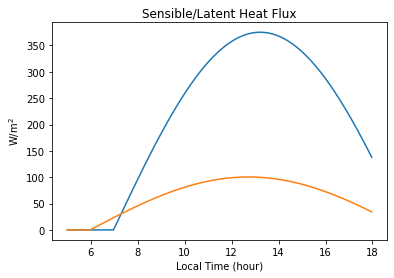

In [130]:

###### Construct time varying data for 3d arrays (time,lat,lon) ######

## Generate boundary forced variables ##
ishflx = case_iop['vname'].index('shflx')
shflx0 = case_iop['vval'][ishflx]
#vdesc_i = case_iop['vdesc'][ishflx]

ilhflx = case_iop['vname'].index('lhflx')
lhflx0 = case_iop['vval'][ilhflx]
#vdesc_i = vdesc[vname.index('lhflx')]

## SAS case study: Daylight variation of sfce fluxes (sfc fluxes to be converted to energy flux) ##

# Daylight fluxes only last to 16.5LT after than, if needed fluxes are zero.
## SHFLX ##
shflx = np.copy(var_3d)  

shflx[:,0,0] = shflx0*cp_air*np.sin(np.pi*(time-sflux_zstart+dtime)/tperiod_sflux)


## LHFLX ##
lhflx = np.copy(var_3d)
lhflx[:,0,0] = 0.001*lhflx0*Lv*np.sin(np.pi*(time-lflux_zstart+dtime)/tperiod_lflux) # Convert g/kg -> kg/kg


# Zero out for fluxes beynod original flux reaching zero time. 
shflx[shflx < 0] = 0 ; lhflx[lhflx < 0] = 0 

## Initialize "Dataset" ##
iop_out = xr.Dataset({'shflx': (['time','lon','lat'],  shflx)},
                     coords={'tsec': ('tsec',time),  
                             'lev': ('lev',np.float32(plevs)), 
                             'lon': ('lon',[np.float32(iop_lon)]), 
                             'lat': ('lat', [np.float32(iop_lat)]) })

iop_out['lhflx'] = (iop_out_c3, lhflx)

## IOP out add attributes ##
iop_out.attrs['title'] = 'Southeast Atmosphere Study (SipAS) campaign: Ideal day for the Mixed Layer Model (MXLCH, it can be accessed athttps://github.com/classmodel/mxlch)'
iop_out.attrs['iop_file'] = case_iop['iop_file_out']
iop_out.attrs['publication'] = 'https://doi.org/10.5194/acp-16-7725-2016'
iop_out.attrs['creation_date'] = str(dt.datetime.today())
iop_out.attrs['creation_owner'] = 'Rich Neale, NCAR'

## Dimenstion/Coord info.
iop_out.lat.attrs = iop_in.lat.attrs
iop_out.lon.attrs = iop_in.lon.attrs

## Copy attributes of tsec from iop_in ##
iop_out.lev.attrs = iop_in.lev.attrs
iop_out.tsec.attrs['long_name'] = iop_in.tsec.attrs['long_name'] 
iop_out.tsec.attrs['units'] = iop_in.tsec.attrs['units'] 


## Quick plots ##

#fig,ax = mp.subplots(nrows=1, ncols=1,figsize=(12, 5))

mp.plot((time/sph)-6,lhflx[:,0,0]) 
mp.plot((time/sph)-6,shflx[:,0,0]) 


mp.xlabel('Local Time (hour)') ; mp.ylabel('W/m$^2$') 
mp.title('Sensible/Latent Heat Flux') 


# Fig to file.
mp.savefig(case_iop['iop_file_out']+'_lxflx_shflx.png', dpi=300)              


In [135]:
######################################
### Constructing vertical profiles ###
######################################

## Read in SCAM IOP template here (split into a function at some point)
#plevs = np.array([10, 20, 100, 150, 200, 300, 400, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 975, 1000])
#plevs = np.arange(10,1000,10)


## Convert trop theta values into temperature given plevs ##
#plevs = iop_in['lev']




## Z of plevels, tricky don't have T yet ##
dp_levs = np.diff(plevs)


################################
## 1. Grab CASE values ##
################################

pblh = case_iop['zinv_bot'] # Bottom ov inversation layer (NCAR SAS value is not Su et al value)

ii = case_iop['vname'].index('the_trop') ; the_ft = case_iop['vval'][ii]
ii = case_iop['vname'].index('the_bl') ; the_bl = case_iop['vval'][ii]
ii = case_iop['vname'].index('the_trop') ; dthedp_ft = case_iop['vval'][ii]
ii = case_iop['vname'].index('q_trop') ; q_ft = case_iop['vval'][ii]
ii = case_iop['vname'].index('q_bl') ; q_bl= case_iop['vval'][ii]
ii = case_iop['vname'].index('q_lr') ; dqdp_ft = case_iop['vval'][ii]



#q_ft = vval[vname.index('q_trop')]
#q_bl = vval[vname.index('q_bl')]
#dqdp_ft = vval[vname.index('q_lr')]


################################
## 2. Find PBL top level ##
################################

# Temperature profile based just on the_bl
t_bl = the_bl*(plevs/p0)**r_cp  
#print(t_bl)
# Assumed t is just below 800mb
p_bl_top = 80000. # hpa estimate pf PBL top.
t_bl_ave = np.average(t_bl[np.where(plevs >= p_bl_top)])

# Z levels based on t_bl
z_plevs = (r_gas/grav)*t_bl*np.log(ps/plevs)
z_plevs = z_plevs-z_plevs[-1]

# Where's the PBL top?
ipbl_levs = np.where(z_plevs <= pblh)
npbl_levs = np.size(ipbl_levs)

# Highest level of PBL
ipbl_min = np.amin(ipbl_levs)

# Wheres the inversion layer (ilh) top?
iil_levs = np.where(z_plevs <= case_iop['zinv_top'])
nil_levs = np.size(iil_levs)

# Highest level of inversation transtion layer
iil_min = np.amin(iil_levs)





##############################################################
## 3. Use Gradient+mean and specified theta, q for profiles ##
##############################################################

q_plevs = np.full(nplevs, q_bl)
the = np.full(nplevs, the_bl) # Initialize theta pbl as numpys

dq_inv = q_bl-q_ft
dthe_inv = the_ft-the_bl 
dz_inv = case_iop['zinv_top']-pblh

# Construct profiles of the/q, starting at ipbl+1 in the transition zone then working up, to the FT gradient zone
print(ipbl_levs)
for ip in range(ipbl_min-1,-1,-1):  # Loop from PBL top upwards, as the PBL values are set.
    print("hi")
    # Temp profile
    t_ip = the[ip-1]*(plevs[ip-1]/p0)**r_cp # Temp at the level below
 
    rho = plevs[ip]/(r_gas*t_ip)  # Density at lev-=ip
    dz = dp_levs[ip]/(rho*grav)
#    the[ip] = the[ip+1]+dthedp_ft*dz
    
# q/theta profile acros PBL depth between BL and FT values

    if (ip >= iil_min-1): # Just needs to be below iil_min as we are starting at PBL top
        q_plevs[ip] = q_bl-dq_inv*(z_plevs[ip]-pblh)/dz_inv
        the[ip]     = the_bl+dthe_inv*(z_plevs[ip]-pblh)/dz_inv
        
    else: # Now doing the free troposphere
        q_plevs[ip] = q_plevs[ip+1]+dqdp_ft*dz
        the[ip] = the[ip+1]+dthedp_ft*dz
         
            
            
## Set temp estimate ##

temp_plevs = the*(plevs/p0)**r_cp


#theq = mpy.dewpoint_from_specific_humidity(plevs*units.pa, temp_plevs*units.K, q_plevs*units.kg)

## Don't let q go below a minimum (linear gradient will do that), or tail the value expoentially
#q_plevs[np.where(q_plevs <= 0)] = 0.1

################################
## 4. q Exponential tailing ##
################################

print(q_plevs)
ip0 = np.where(q_plevs <= qtail)
print(ip0)
ip0m = np.max(ip0)

## Tailing off exp.
ew = np.exp((dqdt_mult*(plevs[ip0]-plevs[ip0m])/(plevs[ip0m]-pexp))) # Exponential weights
q_plevs[ip0] = q_plevs[ip0m]*ew

## RELHUM ##
plevs_mb = plevs/100.
tempc_plevs = temp_plevs-273.16 
qkg_plevs = q_plevs/1000.

## THETA_L ##
thel_plevs = the-(the/temp_plevs)*(Lv/cp_air)*qkg_plevs

## RELHUM ###
esat = 6.112*np.exp((17.67*tempc_plevs)/(tempc_plevs+243.5))
eair = qkg_plevs*plevs_mb/(0.378*qkg_plevs+0.622)

rh_plevs = 100.*eair/esat


## Quick plots ##

mp.ion()

fig1,axs = mp.subplots(nrows=1, ncols=5,figsize=(15, 5))

mp.suptitle('SAS Initial Condition')

axs[0].set_xlabel('K') ; axs[0].set_ylabel('m') ; axs[0].set_title('Temperature')
axs[1].set_xlabel('K') ; axs[1].set_ylabel('') ; axs[1].set_title('Potential Temperature') ; axs[1].axes.yaxis.set_visible(False)
axs[2].set_xlabel('g/kg') ; axs[2].set_ylabel('')  ; axs[2].set_title('Specific Humditiy'); axs[2].axes.yaxis.set_visible(False)
axs[3].set_xlabel('%') ; axs[3].set_ylabel('') ; axs[3].set_title('Relative Humidity'); axs[3].axes.yaxis.set_visible(False)
axs[4].set_xlabel('K') ; axs[4].set_ylabel('') ; axs[4].set_title('Liq Water Pot. Temperature'); axs[4].axes.yaxis.set_visible(False)


yr0 = -100.
yr1 = 3000.

axs[0].set_ylim([yr0,yr1]) ; axs[1].set_ylim([yr0,yr1]) ; axs[2].set_ylim([yr0,yr1]) ; axs[3].set_ylim([yr0,yr1])
axs[0].set_xlim([-5.,25.]) ; axs[1].set_xlim([295,310]) 

axs[0].plot(tempc_plevs.transpose(), z_plevs) ;  axs[0].vlines(0, 0, z_plevs.max(), linestyle="dashed",lw=1) 
axs[1].plot(the.transpose(), z_plevs) 
axs[2].plot(q_plevs.transpose(), z_plevs)  ; axs[2].vlines(0, 0, z_plevs.max(), linestyle="dashed",lw=1)
axs[3].plot(rh_plevs.transpose(), z_plevs) ; axs[3].vlines(0, 0, z_plevs.max(), linestyle="dashed",lw=1)  
axs[4].plot(thel_plevs.transpose(), z_plevs)  
 
    
mp.savefig(iop_file_out+'_IOP_ICs.png')
    
#mp.show()    
#fig.tight_layout(pad=2.) # Space apart a bit


#z_plevs = (r_gas/grav)*np.mean(temp_plevs)*np.log(ps/plevs)

(array([0, 1, 2, 3, 4, 5, 6]),)
[11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8
 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8 11.8

/Users/rneale/miniconda3/envs/neale_myenv/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in power
/Users/rneale/miniconda3/envs/neale_myenv/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in multiply
/Users/rneale/miniconda3/envs/neale_myenv/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in multiply
/Users/rneale/miniconda3/envs/neale_myenv/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in subtract
/Users/rneale/miniconda3/envs/neale_myenv/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in power
/Users/rneale/miniconda3/envs/neale_myenv/lib/python3.7/site-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in multiply


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:


### Constant value copying ###

# Omega (units are /s which don't make sense, maybe m/s)
w_sub = vval[vname.index('w_sub')]
omega = np.copy(var_4d) # Copy 4D array

# divt and divq (horizontal advection)
q_adv = vval[vname.index('q_adv')]
the_adv = vval[vname.index('the_adv')]

divT = np.copy(var_4d) # Copy 4D array, need to convert to Temp in the array u.del(the)->u.del(T)
divq = np.full_like(var_4d,-0.001*q_adv) # Single value overwrite everywhere, convert g/kg/s->kg/kg/s
divu = np.copy(var_4d) # Copy 4D arr to u tend
divv = np.copy(var_4d) # Copy 4D arr to v tend

# Calculated above
T = np.copy(var_4d)  
q = np.copy(var_4d) 

U = np.copy(var_4d) 
V = np.copy(var_4d) 


## Send variables to "dataset" ##
for it in range(0, ntsteps):
    T[it,:,0,0] = temp_plevs.data[:]
    q[it,:,0,0] = q_plevs.data[:]
    divT[it,:,0,0] = the_adv*(plevs/p0)**r_cp # Constant in theta bbut not in T.

    rho = plevs/(r_gas*t_ip)  # Convert dw/dz -> dw/dp
    omega[it,:,0,0] = w_sub/(rho*grav)
# Geo wind
    U[it,:,0,0] = u_g
    V[it,:,0,0] = v_g
    
## Write To IOP file ##

# 3D #
iop_out.lhflx.attrs = iop_in.lhflx.attrs 
iop_out.shflx.attrs = iop_in.shflx.attrs 

# 4D #
iop_out['T'] = (iop_out_c4, T)
iop_out['q'] = (iop_out_c4, np.float_(q/1000.)) # Funny SCAM requirements

iop_out['u'] = (iop_out_c4, U)
iop_out['v'] = (iop_out_c4, V)

if lno_lsf: # Set ls forcings to zero
    divq.fill(0.) ; divT.fill(0.) ; omega.fill(0.) ;  divu.fill(0.) ; divv.fill(0.) ; 
    
iop_out['divq'] = (iop_out_c4, divq)
iop_out['divT'] = (iop_out_c4, divT)
iop_out['omega'] = (iop_out_c4, omega)

iop_out['divu'] = (iop_out_c4, divu)
iop_out['divv'] = (iop_out_c4, divv)




for iv in iop_out.data_vars:
    print(iv)
    if not iv in ['divu','divv']:
        iop_out[iv].attrs = iop_in[iv].attrs 
    iop_out[iv].attrs['_FillValue'] = -9999.
    iop_out[iv].attrs['missing_value'] = -9999. 

## Date stamp ##
iop_out.attrs['creation_date'] = str(dt.datetime.now())

## bdate copy of attributes from old iop and add new value

iop_out['bdate'] = bdate
iop_out['bdate'].attrs = iop_in['bdate'].attrs

#### Send everything to output IOP file
iop_out.to_netcdf(iop_file_out)



#################################
#   Chemical Initial Conditions #
#################################


def chem_ics: 
    
    chem_spec = {}
    chem_spec['O3'] = ['Ozone',25.17,0.007437,26.26,0.004336,23.33,0.007413,28.43,0.004745]  
    chem_sepc['H2O2'] = ['H2O2',1.471,0.0001219,1.475,0.0001114,2.249,0.0007014,0.2173,0.0003611]
    chem_spec['CO'] = ['Carbon Monoxide',107.05,0.006602,108.17,0.009788,107.47,0.009051,85.97,0.002193]
    chem_spec['NO'] =

    







##### END #####




#fig, axes = mp.subplots(ncols=2, nrows=1)
#x_array = np.random.randn(6, 10)
#y_array = np.random.randn(6, 10)

#i = 0
#for row in axes:
#    x = x_array[i] 
#    y = y_array[i]
#    row.plot(x, y)
#    i += 1
#plt.tight_layout()
#plt.show()
